# 1.问题分析

## 1.1.问题类别

## 1.2.特征分析 

## 1.3.数据挖掘

# 2.准备工作

## 2.1.准备工具包

In [1]:
import numpy as np
import pandas as pd
 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMRegressor
import math


from sklearn.model_selection import ShuffleSplit

from sklearn.model_selection import StratifiedKFold


%matplotlib inline

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 2.2.原始数据准备(不进行任何清洗)

In [2]:
train_raw = pd.read_csv('../data/public_raw.train.csv')
test_raw = pd.read_csv('../data/public_raw.test.csv')

train_raw['is_train']=1
test_raw['is_train']=0

df = pd.concat([train_raw, test_raw],sort=False)

rep_cols = {'ID':'ID', 
 '板温':'board_t', 
 '现场温度':'env_t', 
 '光照强度':'light_strength', 
 '转换效率':'efficiency', 
 '转换效率A':'efficiency_A', 
 '转换效率B':'efficiency_B', 
 '转换效率C':'efficiency_C', 
 '电压A':'V_A',
 '电压B':'V_B', 
 '电压C':'V_C', 
 '电流A':'I_A', 
 '电流B':'I_B', 
 '电流C':'I_C', 
 '功率A':'P_A', 
 '功率B':'P_B', 
 '功率C':'P_C', 
 '平均功率':'P_avg', 
 '风速':'wind_speed',
 '风向':'wind_direction', 
 '发电量':'y'
}

df.rename(index=str, columns=rep_cols, inplace=True)

df.sort_values(by=['ID'],ascending=True, inplace=True)

df.reset_index(drop=True, inplace=True)

# 3.数据清洗

In [3]:
# #原始路线
# all_data = df.copy()
# bad_feature = ['env_t', 'V_A', 'V_B', 'V_C', 'I_B', 'I_C', 'efficiency', 'efficiency_A', 'efficiency_B', 'efficiency_C']
# bad_index1 = all_data[bad_feature][
#     (all_data[bad_feature] > all_data[bad_feature].mean() + 2 * all_data[bad_feature].std()) | 
#     (all_data[bad_feature] < all_data[bad_feature].mean() - 2 * all_data[bad_feature].std())
# ].dropna(how='all').index
# bad_index2 = all_data[
#     ((all_data['V_A']<500)&(all_data['V_A']!=0))|
#     ((all_data['V_B']<500)&(all_data['V_B']!=0))|
#     ((all_data['V_C']<500)&(all_data['V_C']!=0))].index
# bad_index = pd.Int64Index(list(bad_index1)+list(bad_index2))

# # bad_index = all_data[bad_feature][
# #     (all_data[bad_feature] > all_data[bad_feature].mean() + 2 * all_data[bad_feature].std()) | 
# #     (all_data[bad_feature] < all_data[bad_feature].mean() - 2 * all_data[bad_feature].std())
# # ].dropna(how='all').index



# bad_data = all_data.loc[bad_index].sort_values(by='ID', ascending=True)






# # 上下记录均值替代异常值
# for idx, line in bad_data.iterrows():
#     ID = line['ID']
#     col_index = line[bad_feature][ 
#         (line[bad_feature] > all_data[bad_feature].mean() + 3 * all_data[bad_feature].std())| 
#         (line[bad_feature] < all_data[bad_feature].mean() - 3 * all_data[bad_feature].std())
#     ].index
#     index = all_data[all_data['ID'] == ID].index
    
#     # idx - before_offset, CV  0.8684
#     before_offset = 1
#     while (idx + before_offset)in bad_index:
#         before_offset += 1

#     after_offset = 1
#     while (idx + after_offset) in bad_index:
#         after_offset += 1
    
#     replace_value = (all_data.loc[index - before_offset, col_index].values + all_data.loc[index + after_offset, col_index].values) / 2
#     all_data.loc[index, col_index] = replace_value[0]

    


In [4]:
rolling_mask_two = [-i for i in range(1,2)]+[i for i in range(1,2)]
rolling_mask_four = [-i for i in range(1,3)]+[i for i in range(1,3)]
rolling_mask_six = [-i for i in range(1,4)]+[i for i in range(1,4)]
rolling_mask_eight = [-i for i in range(1,5)]+[i for i in range(1,5)]
rolling_mask_ten = [-i for i in range(1,6)]+[i for i in range(1,6)]

In [5]:
#计算偏差率的辅助列
# for c in ['I_A','I_B','I_C','V_A','V_B','V_C']:
for c in ['I_A','I_B','I_C']:
    df[c+'_avg_sequence'] = np.nanmean([df[c].shift(i) for i in rolling_mask_eight],axis=0)
    df[c+'_exception_ratio'] = np.abs(df[c]-df[c+'_avg_sequence'])/df[c+'_avg_sequence']
    df[c+'_cor'] = df[c]
    
    #out of range
    oor_index = df[df[c]>20].index
    print(oor_index)
    
#     outlier_index = df[df[c+'_exception_ratio']>1.6].index
#     print(outlier_index)
    
#     ab_index = pd.Int64Index(set(list(oor_index)+list(outlier_index)))
    ab_index = pd.Int64Index(set(list(oor_index)))
    print(ab_index)
    
    ab_data = df.loc[ab_index].sort_values(by='ID', ascending=True)
    
    print(ab_data[['ID', 'V_A', 'V_B', 'V_C', 'I_A', 'I_B', 'I_C', 'y']])
    
    # 上下记录均值替代异常值
    for idx, line in ab_data.iterrows():
        ID = line['ID']
        value = line[c]
        
        index = df[df['ID'] == ID].index
            
        before_offset = 1
        while (idx - before_offset)in ab_index:
            before_offset += 1

        after_offset = 1
        while (idx + after_offset) in ab_index:
            after_offset += 1
    
        print('ID :' + str(ID))
        print(value, 'is abnormal as value of ',c)
        replace_value = (df.loc[index - before_offset, c].values + df.loc[index + after_offset, c].values) / 2
        df.loc[index, c+'_cor'] = replace_value[0]
        print('Has been replaced by '+str(replace_value[0]))
    
    df[c] = df[c+'_cor']
    df.drop(columns=[c+'_cor',c+'_exception_ratio',c+'_avg_sequence'],axis=1,inplace=True)
    

# Corrections for presumed outlier points for I_A 
    
for c in ['I_A']:
    df[c+'_avg_sequence'] = np.nanmean([df[c].shift(i) for i in rolling_mask_eight],axis=0)
    df[c+'_exception_ratio'] = np.abs(df[c]-df[c+'_avg_sequence'])/df[c+'_avg_sequence']
    df[c+'_cor'] = df[c]
    
#     #out of range
#     oor_index = df[df[c]>20].index
#     print(oor_index)
    
    outlier_index = df[df[c+'_exception_ratio']>4].index
    print('outlier_index :\n',outlier_index)
    
#     ab_index = pd.Int64Index(set(list(oor_index)+list(outlier_index)))
    ab_index = pd.Int64Index(set(list(outlier_index)))
    print(ab_index)
    
    ab_data = df.loc[ab_index].sort_values(by='ID', ascending=True)
    
    print(ab_data[['ID', 'V_A', 'V_B', 'V_C', 'I_A', 'I_B', 'I_C', 'y']])
    
    # 上下记录均值替代异常值
    for idx, line in ab_data.iterrows():
        ID = line['ID']
        value = line[c]
        
        index = df[df['ID'] == ID].index
            
        before_offset = 1
        while (idx - before_offset)in ab_index:
            before_offset += 1

        after_offset = 1
        while (idx + after_offset) in ab_index:
            after_offset += 1
    
        print('ID :' + str(ID))
        print(value, 'is abnormal as value of ',c)
        replace_value = (df.loc[index - before_offset, c].values + df.loc[index + after_offset, c].values) / 2
        df.loc[index, c+'_cor'] = replace_value[0]
        print('Has been replaced by '+str(replace_value[0]))
    
    df[c] = df[c+'_cor']
    df.drop(columns=[c+'_cor',c+'_exception_ratio',c+'_avg_sequence'],axis=1,inplace=True)

        
        
        
        
        
for c in ['V_A','V_B','V_C']:
    df[c+'_avg_sequence'] = np.nanmean([df[c].shift(i) for i in rolling_mask_eight],axis=0)
    df[c+'_exception_ratio'] = np.abs(df[c]-df[c+'_avg_sequence'])/df[c+'_avg_sequence']
    df[c+'_cor'] = df[c]
    
    #out of range
    oor_index = df[(df[c]>800)|((df[c]<500)&(df[c]!=0))].index
    print(oor_index)
    
#     outlier_index = df[df[c+'_exception_ratio']>1.6].index
#     print(outlier_index)
    
#     ab_index = pd.Int64Index(set(list(oor_index)+list(outlier_index)))
    ab_index = pd.Int64Index(set(list(oor_index)))
    print(ab_index)
    
    ab_data = df.loc[ab_index].sort_values(by='ID', ascending=True)
    
    print(ab_data[['ID', 'V_A', 'V_B', 'V_C', 'I_A', 'I_B', 'I_C', 'y']])
    
    # 上下记录均值替代异常值
    for idx, line in ab_data.iterrows():
        ID = line['ID']
        value = line[c]
        
        index = df[df['ID'] == ID].index
            
        before_offset = 1
        while (idx - before_offset)in ab_index:
            before_offset += 1

        after_offset = 1
        while (idx + after_offset) in ab_index:
            after_offset += 1
    
        print('ID :' + str(ID))
        print(value, 'is abnormal as value of ',c)
        replace_value = (df.loc[index - before_offset, c].values + df.loc[index + after_offset, c].values) / 2
        df.loc[index, c+'_cor'] = replace_value[0]
        print('Has been replaced by '+str(replace_value[0]))
    
    df[c] = df[c+'_cor']
    df.drop(columns=[c+'_cor',c+'_exception_ratio',c+'_avg_sequence'],axis=1,inplace=True)

        
        

# Correct Power Features        
df['P_A']=df['I_A']*df['V_A']
df['P_B']=df['I_B']*df['V_B']
df['P_C']=df['I_C']*df['V_C']

df['P_avg']=1/3*(df['P_A']+df['P_B']+df['P_C'])




# df.drop(columns=['I_A','I_B','I_C','V_A','V_B','V_C','P_A','P_B','P_C','P_avg'],axis=1,inplace=True)
# df.drop(columns=['I_A_avg_sequence','I_A_exception_ratio','I_B_avg_sequence','I_B_exception_ratio','I_C_avg_sequence','I_C_exception_ratio','V_B_avg_sequence','V_B_exception_ratio','V_A_avg_sequence','V_A_exception_ratio','V_C_avg_sequence','V_C_exception_ratio',],axis=1,inplace=True)


Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Empty DataFrame
Columns: [ID, V_A, V_B, V_C, I_A, I_B, I_C, y]
Index: []
Int64Index([14, 859, 981, 1065, 1237, 1419, 3303, 3305, 3309, 3311, 3313], dtype='int64')
Int64Index([3303, 1065, 3305, 1419, 3309, 14, 3311, 3313, 1237, 981, 859], dtype='int64')
        ID    V_A  V_B  V_C   I_A     I_B   I_C         y
14      22  65382    7  107  7.19  645.39  2.75  5.440741
859    948  65394    4   14  6.87  638.94  2.37       NaN
981   1070  65477   41  692  2.62  653.71  3.15       NaN
1065  1173  65408   22  250  7.04  649.75  2.75  7.753474
1237  1362  65386   23  244  7.00  652.02  2.79  7.806384
1419  1565  65420    8  260  6.93  653.23  0.83       NaN
3303  3597  65419   10   63  6.93  643.45  2.70       NaN
3305  3599  65419    5   64  6.97  643.58  3.35  0.268685
3309  3603  65420    3   67  7.01  643.75  3.16  0.286363
3311  3605  65420   11   67  7.01  643.83  3.36  0.278587
3313  3607  65420   15   68  7.09  643.94  0.03  

Int64Index([   14,   499,   527,   528,   529,   530,   531,   673,   859,
              981,  1065,  1066,  1067,  1178,  1237,  1326,  1373,  1419,
             1520,  1561,  1722,  1950,  2036,  2071,  2214,  2364,  2454,
             2567,  2629,  2670,  2890,  3108,  3136,  3253,  3254,  3255,
             3303,  3305,  3309,  3311,  3313,  3316,  3317,  3318,  3429,
             4068,  5083,  5488,  5565,  6976,  7281, 14216, 15833, 15971],
           dtype='int64')
Int64Index([ 2567, 14216,  1419,    14,   527,   528,   529,   530,   531,
             2454,  2071,  1561,  1178,  1950,   673,  3108,  2214,  1065,
             1066,  1067,  1326,  3253,  3254,  3255,  1722,  2364,  5565,
             3136,  6976,  2629,  2890,   981,  1237, 15833,   859,  5083,
             1373, 15971,  4068,  3429,  3303,  3305,  3309,  2670,  3311,
             1520,  3313,  5488,   499,  2036,  3316,  3317,  3318,  7281],
           dtype='int64')
          ID    V_A    V_B    V_C    I_A    I_

Has been replaced by 722.5
ID :135.0
65498.0 is abnormal as value of  V_C
Has been replaced by 677.0
ID :512.0
23.0 is abnormal as value of  V_C
Has been replaced by 665.0
ID :543.0
15.0 is abnormal as value of  V_C
Has been replaced by 679.5
ID :593.0
3.0 is abnormal as value of  V_C
Has been replaced by 338.5
ID :594.0
3.0 is abnormal as value of  V_C
Has been replaced by 338.5
ID :595.0
65406.0 is abnormal as value of  V_C
Has been replaced by 338.5
ID :737.0
65514.0 is abnormal as value of  V_C
Has been replaced by 645.0
ID :948.0
14.0 is abnormal as value of  V_C
Has been replaced by 697.0
ID :1173.0
250.0 is abnormal as value of  V_C
Has been replaced by 706.5
ID :1174.0
250.0 is abnormal as value of  V_C
Has been replaced by 706.5
ID :1175.0
27.0 is abnormal as value of  V_C
Has been replaced by 706.5
ID :1286.0
65438.0 is abnormal as value of  V_C
Has been replaced by 716.5
ID :1362.0
244.0 is abnormal as value of  V_C
Has been replaced by 700.5
ID :1451.0
27.0 is abnormal as v

# 4.特征工程

## 4.1.增加前后有效发电量均值

In [6]:
# df = all_data.copy()



#前二后二
next_one = []
prev_one = []
next_id = []
prev_id = []

second_next_one = []
second_prev_one = []

df_len = df.shape[0]

i_y =df.columns.get_loc("y")

def get_prev_nn_index(cur_i):
    prev_i = cur_i-1
    while(prev_i>=0 and pd.isnull(df.iat[prev_i,i_y])):
        prev_i-=1
    return prev_i

def get_next_nn_index(cur_i):
    prev_i = cur_i+1
    while(prev_i<df_len and pd.isnull(df.iat[prev_i,i_y])):
        prev_i+=1
    return prev_i

for i in range(df_len):
    f_pre_i=get_prev_nn_index(i)
    if(f_pre_i)<0:
        prev_one.append(np.nan)
        prev_id.append(0)
    else:
        prev_one.append(df.iat[f_pre_i,i_y])
        prev_id.append(f_pre_i)
        
    s_pre_i=get_prev_nn_index(f_pre_i)
    if (s_pre_i)<0:
        second_prev_one.append(np.nan)
    else:
        second_prev_one.append(df.iat[s_pre_i,i_y])
    
    f_next_i=get_next_nn_index(i)
    if(f_next_i<df_len):
        next_one.append(df.iat[f_next_i,i_y])
        next_id.append(f_next_i)
    else:
        next_one.append(np.nan)
        next_id.append(df_len)
    
    s_next_i=get_next_nn_index(f_next_i)
    if(s_next_i<df_len):
        second_next_one.append(df.iat[s_next_i,i_y])
    else:
        second_next_one.append(np.nan)
        

df['next_value'] = next_one
df['prev_value'] = prev_one
df['avg_value'] = np.nanmean([df['next_value'], df['prev_value']],axis=0)

df.drop(['next_value','prev_value'],1,inplace=True)



## 4.2.增加前后功率均值

In [7]:
def add_avg(df):
    array = np.array(df["P_avg"])
    newarray=[]
    num = 0
    for i in np.arange(len(array)):
        for j in np.arange(10):
            if i<10:
                num = (array[j-1]+array[j-2]+array[j-3])/3
            if i>=10:
                num = (array[i-1]+array[i-2]+array[i-3]+array[i-5]+array[i-6]+array[i-7]+array[i-8]+array[i-9])/9
        newarray.append(num)
    df["old_SoCalledSF_P_avg"] = newarray
    return df

df = add_avg(df)

# 5.训练集测试集数据准备

## 5.1.去除训练集的重复样本

In [8]:
# 拆分数据

train_data = df[df['is_train']==1]
test_data = df[df['is_train']==0]
len(train_data), len(test_data)

(9000, 8409)

In [9]:
# 准备提交结果

df_result = pd.DataFrame()
df_result['ID'] = list(test_data['ID'])
special_missing_ID = test_data[test_data[(test_data == 0) | (test_data == 0.)].count(axis=1) > 13]['ID']

In [10]:
# l_drop_base=['I_A','I_B','I_C','V_A','V_B','V_C','P_A','P_B','P_C','P_avg']
# l_drop =[]
# for c in l_drop_base:
#     l_drop.append(c+'_cor')
# print(l_drop)
    

In [11]:
print('去重前训练集条数:' +str(train_data.shape[0]))
# train_data = train_data.drop_duplicates(train_data.columns.drop(['ID','avg_value','old_SoCalledSF_P_avg']), keep='first')
# train_data = train_data.drop_duplicates(train_data.columns.drop(['ID','avg_value','old_SoCalledSF_P_avg']+l_drop), keep='first')
train_data = train_data.drop_duplicates(train_data.columns.drop(['ID','avg_value','old_SoCalledSF_P_avg']), keep='first')
print('去重后训练集条数:' +str(train_data.shape[0]))

去重前训练集条数:9000
去重后训练集条数:8918


## 5.2.使训练集样本分布更合理

In [12]:
# def improve_train_test_data(train_data, test_data, poly=False, select=False):
#     Y = train_data['y']
#     X = train_data.drop(['y','ID','is_train'], axis=1)
#     test_data = test_data.drop(['y','ID','is_train'], axis=1)
    
#     polynm = None
#     if poly:
#         from sklearn.preprocessing import PolynomialFeatures
#         polynm = PolynomialFeatures(degree=2, interaction_only=True)
#         X = polynm.fit_transform(X)
#         test_data = polynm.transform(test_data)
        
#     X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=123)
    
#     sm = None
#     if select:
#         from sklearn.feature_selection import SelectFromModel
#         sm = SelectFromModel(GradientBoostingRegressor(random_state=2))
#         X_train = sm.fit_transform(X_train, Y_train)
#         X_val = sm.transform(X_val)
#         test_data = sm.transform(test_data)
        
#     train_X = np.concatenate([X_train, X_val])
#     train_Y = np.concatenate([Y_train, Y_val])

# #     sm = None
# #     if select:
# #         from sklearn.feature_selection import SelectFromModel
# #         sm = SelectFromModel(GradientBoostingRegressor(random_state=2))
# #         X = sm.fit_transform(X, Y)
# #         test_data = sm.transform(test_data)
    
# #     train_X = X
# #     train_Y = Y
#     test_X = test_data
        
#     return train_X, train_Y, test_X

In [13]:
def improve_train_test_data(train_data, test_data, poly=False, select=False):
    Y = train_data[['y']]
    X = train_data.drop(['y','is_train','I_B','I_C'], axis=1)
    test_X = test_data.drop(['y','is_train','I_B','I_C'], axis=1)
        
    return X, Y, test_X

In [14]:
# # X_train, X_test, y_train, y_test, sub_data, sm, polynm = generate_train_data(train_data, test_data, poly=True, select=True)
# X_train, X_test, y_train, y_test, sub_data, sm, polynm = generate_train_data(train_data, test_data)

# train_X = np.concatenate([X_train, X_test])
# train_Y = np.concatenate([y_train, y_test])



# test_X = sub_data

In [15]:
# train_X, train_Y, test_X = improve_train_test_data(train_data, test_data, poly=True, select=True)
train_X, train_Y, test_X = improve_train_test_data(train_data, test_data, poly=False, select=False)

# 6.Cross Validation

In [35]:
# 定义打分函数,  SCORE = 1/(1+RMSE)
def cal_score(mse):
    if isinstance(mse, float):
        return 1 / (1 + math.sqrt(mse))
    else:
        return np.divide(1, 1 + np.sqrt(mse))

# def cal_score(mse):
#     return np.divide(1, 1 + np.sqrt(mse))

# 定义交叉验证函数  
def cross_validate(models, X, Y, test_X, cv=10):
    model_name, mse_avg, score_avg, rmse_r, score_r = [], [], [], [], []
    test_preds_all_folds = []
    for i, model in enumerate(models):
        #获取模型名
        name = str(i + 1) + '.' + str(model) 
#         print(i + 1,'- Model:', str(model).split('(')[0])
        print(name)
#         model_name.append(str(i + 1) + '.' + str(model).split('(')[0])
        model_name.append(name.split('(')[0])
        #计算metric
        
        skf = KFold(10, shuffle=True, random_state=2018)
        Y_pred = np.zeros(X.shape[0])
        for train_idx,val_idx in skf.split(X):
            print('train_idx: \n',str(len(train_idx)),train_idx)
            print('val_idx: \n',str(len(val_idx)),val_idx)
            X_train, X_val, Y_train, Y_val = X.iloc[train_idx], X.iloc[val_idx], Y.iloc[train_idx], Y.iloc[val_idx]
            model.fit(X_train, Y_train)
            Y_pred[val_idx] = model.predict(X_val)
            print('Y_pred: \n',Y_pred)
            test_preds_all_folds.append(model.predict(test_X))
        rmse_c = np.sqrt(mean_squared_error(Y, Y_pred))
        score_c = 1/(1+rmse_c)
        rmse_r.append(rmse_c)
        score_r.append(score_c)
        
        test_preds = np.mean(test_preds_all_folds, axis=0)
        
        
        
#         folds=strat_k_fold.split(X,Y)
        #apply shuffling to cross_val_score
#         strat_k_fold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
#         nmse = cross_val_score(model, X, Y, cv=cv, scoring='neg_mean_squared_error')
    
#         nmse = cross_val_score(model, X, Y, cv=cv, scoring='neg_mean_squared_error')
#         avg_mse = np.average(-nmse)
#         mse_avg.append(avg_mse)
#         #计算分数
#         scores = cal_score(-nmse)
#         avg_score = np.average(scores)    
#         score_avg.append(avg_score)
#         print('MSE:', -nmse)
#         print('Score:', scores)
#         print('Average MSE:', avg_mse, ' - Score:', avg_score, ' - Score_c:', score_c, '\n')
        print('Score:', score_c, '\n')
    res = pd.DataFrame()
    res['Model'] = model_name
#     res['Avg MSE'] = mse_avg
#     res['Avg Score'] = score_avg
    res['Score Customize'] = score_r
    res['RMSE Customize'] = rmse_r
    return res, test_preds

In [17]:
#基学习器

xgbt1 = xgb.XGBRegressor(n_estimators=950, max_depth=3, max_features='sqrt', random_state=321, n_jobs=8)
xgbt2 = xgb.XGBRegressor(n_estimators=1000, max_depth=3, max_features='sqrt', random_state=456, n_jobs=8)
xgbt3 = xgb.XGBRegressor(n_estimators=1100, max_depth=3, max_features='sqrt', random_state=789)
# n_estimators=1000  max_depth=5  'sqrt'  GradientBoostingRegressor 最佳参数 ,learning_rate=0.08
gbdt1 = GradientBoostingRegressor(n_estimators=800, max_depth=4, max_features='log2', random_state=123,learning_rate=0.08)
gbdt2 = GradientBoostingRegressor(n_estimators=900, max_depth=4, max_features='log2', random_state=456,learning_rate=0.08)
gbdt3 = GradientBoostingRegressor(n_estimators=1000, max_depth=5, max_features='log2', random_state=789,learning_rate=0.08)
# n_estimators=700, max_features='auto', random_state=2, n_jobs=8,max_depth=10
forest1 = RandomForestRegressor(n_estimators=800, max_features='sqrt', random_state=7, n_jobs=8)
forest2 = RandomForestRegressor(n_estimators=900, max_features='log2', random_state=9, n_jobs=8)
forest3 = RandomForestRegressor(n_estimators=900, max_features='sqrt', random_state=11) 

lgb1 = LGBMRegressor(n_estimators=900, max_depth=5, random_state=5, n_jobs=8) 
lgb2 = LGBMRegressor(n_estimators=850, max_depth=4, random_state=7, n_jobs=8)
lgb3 = LGBMRegressor(n_estimators=720, max_depth=4, random_state=9)
# lgb3 = LGBMRegressor(n_estimators=1000, max_depth=5, random_state=9, )

In [18]:
# 
import lightgbm

def my_val(preds, train_data):
    label = train_data.get_label()
    return 'score', 1/(1+np.sqrt(mean_squared_error(preds, label))), True
def my_obj(preds, train_data):
    labels = train_deata.get_label()

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.08,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': 0
}
# 同样的条件下，此参数设置达到local cv: 0.8575832021441638

# train = train_data.copy()
# test = test_X.copy()


test_predicts = []
val_preds = []

# log_test_predicts = []
# log_val_predicts = []
for idx, seed in enumerate([1,2,3,4,5]):
# for idx, seed in enumerate([1]):
    kf = KFold(10, shuffle=True, random_state=seed)
    
    val_preds.append(np.zeros(train_X.shape[0]))
    for n_fold, (tra_idx, val_idx) in enumerate(kf.split(train_X)):
#         tra = train.iloc[tra_idx]
#         val = train.iloc[val_idx]
#         tst = test.copy()

#         predictor = [c for c in tra.columns.tolist() if c not in['y','I_B','I_C','is_train']]

        train_set = lightgbm.Dataset(
            train_X.iloc[tra_idx],
            train_Y.iloc[tra_idx]['y']
        )

        validation_set = lightgbm.Dataset(
            train_X.iloc[val_idx],
            train_Y.iloc[val_idx]['y']
        )

        model = lightgbm.train(params, train_set, num_boost_round=5000,
                              valid_sets= [validation_set],
                              valid_names=['valid'],
                              early_stopping_rounds=100,
                               feval=my_val,
                              verbose_eval=500)

        val_preds[idx][val_idx] = model.predict(train_X.iloc[val_idx])
        test_predicts.append(model.predict(test_X))

print('local cv:',1/(1+np.sqrt(mean_squared_error(train_Y['y'],np.mean(val_preds,axis=0)))))






Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.028317	valid's score: 0.855962
Early stopping, best iteration is:
[716]	valid's l2: 0.0269006	valid's score: 0.859096
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0170063	valid's score: 0.884636
Early stopping, best iteration is:
[530]	valid's l2: 0.0168919	valid's score: 0.88498
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[214]	valid's l2: 0.0196453	valid's score: 0.877069
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[331]	valid's l2: 0.0143643	valid's score: 0.892976
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.100913	valid's score: 0.758917
Early stopping, best iteration is:
[500]	valid's l2: 0.100913	valid's score: 0.758917
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0177179	valid's

[500]	valid's l2: 0.0220507	valid's score: 0.870705
Early stopping, best iteration is:
[773]	valid's l2: 0.0217678	valid's score: 0.87143
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0181409	valid's score: 0.881299
Early stopping, best iteration is:
[858]	valid's l2: 0.0175545	valid's score: 0.883007
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0147592	valid's score: 0.891673
Early stopping, best iteration is:
[472]	valid's l2: 0.0146343	valid's score: 0.892083
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0192833	valid's score: 0.878068
Early stopping, best iteration is:
[612]	valid's l2: 0.0189874	valid's score: 0.878893
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[327]	valid's l2: 0.0222433	valid's score: 0.870215
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[100]	va

In [19]:
def print_score(train_y, predict_y ):
    print('local cv:',1/(1+np.sqrt(mean_squared_error(train_y, predict_y))))

In [20]:
# 训练得到的模型预测Test_X
wyh_train = np.mean(val_preds,axis=0)
wyh_predict = np.mean(test_predicts,axis=0)  

In [21]:
regrs = [
    xgbt1, gbdt1, forest1, lgb1,
    xgbt2, gbdt2, forest2, lgb2,
    xgbt3, gbdt3, forest3, lgb3
]

regrs_light = [
    lgb3, xgbt3, gbdt3, forest3
]

In [22]:
# cross_validate(models=regrs_light, X = train_X, Y = train_Y)

In [23]:
# cross_validate(models=regrs_light, X = train_X, Y = train_Y['y'])

# 7.Stack

In [24]:
class Stacker(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models
    
    # Train_X: 原始训练集输入矩阵, Train_Y: 原始训练集输出矩阵, Test_X: 原始测试集输入矩阵
    def fit_predict(self, Train_X, Train_Y, Test_X):
        Train_X = np.array(Train_X)
        Train_Y = np.array(Train_Y)
        Test_X = np.array(Test_X)

        folds = list(KFold(n_splits=self.n_splits, shuffle=True, random_state=2018).split(Train_X, Train_Y))       
        
        # 以基学习器预测结果为特征的 stacker训练数据 与 stacker预测数据
        # 原始训练集预测结果容器
        S_train = np.zeros((Train_X.shape[0], len(self.base_models)))
        # 原始测试集预测结果容器
        S_predict = np.zeros((Test_X.shape[0], len(self.base_models)))
        
        
        model_name, score = [], []
        
        for n_model, regr in enumerate(self.base_models):
            name = str(n_model + 1) + '.' + str(regr)
#             print(n_model + 1, 'Base model:', str(regr).split('(')[0])
            model_name.append(name.split('(')[0])
            print(name)
            S_predict_i = np.zeros((Test_X.shape[0], self.n_splits))
            
            for n_fold, (train_idx, test_idx) in enumerate(folds):
                # 将X分为训练集与测试集
                X_train_fold, Y_train_fold, X_test_fold, Y_test_fold = Train_X[train_idx], Train_Y[train_idx], Train_X[test_idx], Train_Y[test_idx]
                print ('Fit fold', (n_fold+1), '...')
                regr.fit(X_train_fold, Y_train_fold)
                Y_pred = regr.predict(X_test_fold)
                # 每折训练得到的模型根据原始训练集中的测试折的输入矩阵预测
                S_train[test_idx, n_model] = Y_pred
                # 每折训练得到的模型根据原始测试集输入矩阵预测
                S_predict_i[:, n_fold] = regr.predict(Test_X)
            
            S_predict[:, n_model] = S_predict_i.mean(axis=1)
            score_i = 1/(1+np.sqrt(mean_squared_error(Train_Y, S_train[:, n_model])))
            score.append(score_i)
            

#         nmse_score = cross_val_score(self.stacker, S_train, Train_Y, cv=5, scoring='neg_mean_squared_error')
#         print('CV MSE:', -nmse_score)
#         print('Stacker AVG MSE:', -nmse_score.mean(), 'Stacker AVG Score:', np.mean(np.divide(1, 1 + np.sqrt(-nmse_score))))

        
#         self.stacker.fit(S_train, Train_Y)
#         res = self.stacker.predict(S_predict)
#         return res, S_train, S_predict
        res_table = pd.DataFrame()
        res_table['Model'] = model_name
        res_table['Score'] = score

        return S_train, S_predict, res_table

In [25]:
# Stack with 4 models

stacking_model = SVR(C=100, gamma=0.01, epsilon=0.01)
stacker = Stacker(10, stacking_model, regrs_light)
S_train, S_predict, table = stacker.fit_predict(train_X, train_Y, test_X)

print('S_train:\n',S_train,'\n','S_predict:\n',S_predict)

1.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=4, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=720,
       n_jobs=-1, num_leaves=31, objective=None, random_state=9,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)
Fit fold 1 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fit fold 2 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fit fold 3 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fit fold 4 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fit fold 5 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fit fold 6 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fit fold 7 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fit fold 8 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fit fold 9 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fit fold 10 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, max_features='sqrt', min_child_weight=1, missing=None,
       n_estimators=1100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=789, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
Fit fold 1 ...
Fit fold 2 ...
Fit fold 3 ...
Fit fold 4 ...
Fit fold 5 ...
Fit fold 6 ...
Fit fold 7 ...
Fit fold 8 ...
Fit fold 9 ...
Fit fold 10 ...
3.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.08, loss='ls', max_depth=5,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=789, subsample=1.0, verbose=0,

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fit fold 2 ...
Fit fold 3 ...
Fit fold 4 ...
Fit fold 5 ...
Fit fold 6 ...
Fit fold 7 ...
Fit fold 8 ...
Fit fold 9 ...
Fit fold 10 ...
4.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=1,
           oob_score=False, random_state=11, verbose=0, warm_start=False)
Fit fold 1 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fit fold 2 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fit fold 3 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fit fold 4 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fit fold 5 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fit fold 6 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fit fold 7 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fit fold 8 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fit fold 9 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fit fold 10 ...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


S_train:
 [[ 1.48810949  1.49961329  1.47679289  1.5959027 ]
 [ 1.72025262  1.67167699  1.71888866  1.74700498]
 [ 2.05450113  2.10437346  1.97131897  2.0349647 ]
 ...
 [10.34185434 10.3502779  10.26892987 10.34740259]
 [ 9.56665643  9.59838009  9.67723723  9.63561366]
 [ 9.07690899  9.18895817  9.15880149  9.31350001]] 
 S_predict:
 [[0.53162361 0.41583386 0.52710884 0.39572983]
 [1.3197746  1.33778083 1.30854553 1.40115571]
 [2.13909506 2.15013087 2.13960081 2.19128228]
 ...
 [9.93801402 9.91859198 9.92932764 9.90987767]
 [9.87606076 9.90655937 9.849855   9.78472577]
 [9.06363481 9.10178289 9.07155724 9.11881196]]


In [26]:
table

,Model,Score
0,1.LGBMRegressor,0.856319
1,2.XGBRegressor,0.859571
2,3.GradientBoostingRegressor,0.858816
3,4.RandomForestRegressor,0.851396


In [27]:
stack_train=pd.DataFrame()
stack_train['LGBM']=S_train[:,0]
stack_train['XGBM']=S_train[:,1]
stack_train['GBM']=S_train[:,2]
stack_train['RF']=S_train[:,3]
stack_train['WYH']=wyh_train
stack_train.head()

,LGBM,XGBM,GBM,RF,WYH
0,1.488109,1.499613,1.476793,1.595903,1.545617
1,1.720253,1.671677,1.718889,1.747005,1.721858
2,2.054501,2.104373,1.971319,2.034965,1.962870
3,2.356387,2.266027,2.345125,2.422188,2.405345
4,2.517721,2.495417,2.507623,2.631366,2.549975


In [28]:
stack_predict=pd.DataFrame()
stack_predict['LGBM']=S_predict[:,0]
stack_predict['XGBM']=S_predict[:,1]
stack_predict['GBM']=S_predict[:,2]
stack_predict['RF']=S_predict[:,3]
stack_predict['WYH']=wyh_predict
stack_predict.head()

,LGBM,XGBM,GBM,RF,WYH
0,0.531624,0.415834,0.527109,0.395730,0.566327
1,1.319775,1.337781,1.308546,1.401156,1.321474
2,2.139095,2.150131,2.139601,2.191282,2.130599
3,3.458713,3.428675,3.378112,3.401181,3.423788
4,3.687951,3.690193,3.642646,3.645653,3.663321


count    4591.000000
mean        3.690791
std         2.740833
min         0.000234
25%         1.366254
50%         3.111472
75%         5.661994
max        11.968650
Name: WYH_bias, dtype: float64

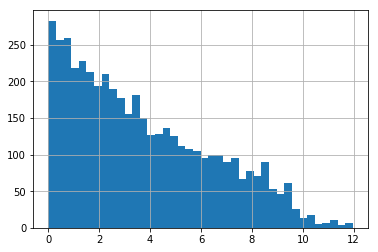

In [29]:
model_compare = stack_train.copy()
model_compare['y'] = train_Y['y']

for c in ['LGBM','XGBM','GBM','RF','WYH']:
    model_compare[c+'_bias'] = np.abs(model_compare[c]-model_compare['y'])


model_compare['WYH_bias'].hist(bins=40)
model_compare['WYH_bias'].describe()

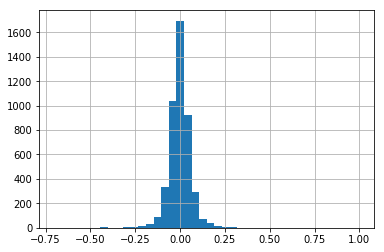

In [30]:
model_compare['WYH_LGBM']=model_compare['WYH_bias']-model_compare['LGBM_bias']
model_compare['WYH_LGBM'].hist(bins=40)

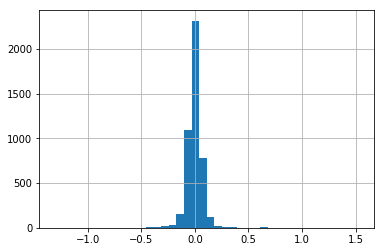

In [31]:
model_compare['WYH_XGBM']=model_compare['WYH_bias']-model_compare['XGBM_bias']
model_compare['WYH_XGBM'].hist(bins=40)

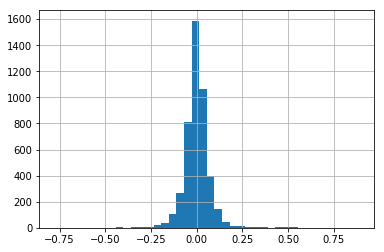

In [32]:
model_compare['WYH_GBM']=model_compare['WYH_bias']-model_compare['GBM_bias']
model_compare['WYH_GBM'].hist(bins=40)

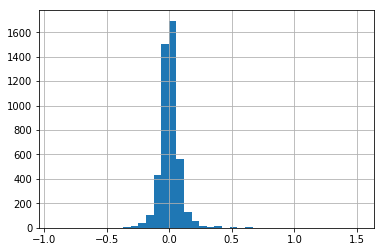

In [33]:
model_compare['WYH_RF']=model_compare['WYH_bias']-model_compare['RF_bias']
model_compare['WYH_RF'].hist(bins=40)

In [36]:
svr = SVR(C=100, gamma=0.01, epsilon=0.01)
res,stack_test_preds = cross_validate(models = [svr], X=stack_train, Y=train_Y['y'], test_X = stack_predict)

stacking_res = res['Score Customize'][0]

1.SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
train_idx: 
 8026 [   0    1    2 ... 8915 8916 8917]
val_idx: 
 892 [   3   13   16   18   20   25   32   37   53   54   55   62   65   90
   97  107  121  131  141  144  145  152  154  159  184  220  239  252
  268  273  291  296  297  302  303  311  317  329  339  350  353  366
  374  376  395  397  398  424  431  434  436  440  457  478  486  491
  506  508  520  524  549  551  566  587  594  603  630  644  647  649
  658  671  674  680  686  700  703  714  730  740  778  779  781  784
  785  786  798  860  870  893  899  902  944  989 1001 1014 1020 1043
 1064 1071 1088 1089 1093 1111 1118 1134 1145 1146 1152 1162 1166 1171
 1245 1253 1254 1265 1284 1287 1294 1300 1322 1334 1340 1348 1357 1391
 1398 1399 1416 1442 1449 1480 1481 1499 1502 1505 1509 1516 1541 1547
 1552 1553 1555 1559 1560 1566 1568 1569 1572 1631 1633 1638 1647 1660
 16

Y_pred: 
 [0.         0.         0.         ... 0.         0.         9.16150331]
train_idx: 
 8026 [   1    2    3 ... 8915 8916 8917]
val_idx: 
 892 [   0   24   56   64   71   73   83   87  112  122  124  128  133  140
  146  151  163  164  174  182  197  202  215  216  219  230  248  272
  276  295  298  306  325  326  346  349  354  359  360  364  369  379
  406  414  418  422  426  439  461  474  479  500  502  503  522  527
  534  541  553  563  573  575  576  582  595  601  611  614  631  643
  648  655  660  663  672  676  705  706  709  712  719  720  722  728
  733  737  750  752  756  757  761  768  795  813  821  846  854  855
  867  875  878  885  896  916  928  937  948  952  956  969  993  995
  999 1011 1038 1065 1078 1087 1099 1101 1106 1117 1121 1131 1144 1154
 1155 1163 1170 1173 1203 1214 1247 1251 1258 1286 1298 1304 1313 1315
 1328 1332 1362 1366 1367 1376 1402 1406 1408 1411 1423 1425 1434 1435
 1436 1466 1468 1487 1489 1503 1504 1514 1521 1531 1538 1539 1543 15

Y_pred: 
 [1.50167958 1.70580025 0.         ... 0.         0.         9.16150331]
train_idx: 
 8026 [   0    1    2 ... 8915 8916 8917]
val_idx: 
 892 [   9   15   28   38   63   68   85  119  139  150  161  165  168  170
  179  186  188  191  194  195  196  198  203  206  224  254  255  266
  267  314  330  362  370  375  382  384  403  441  450  465  472  482
  484  489  490  505  507  513  518  532  535  538  570  574  577  580
  581  583  592  598  600  604  615  622  638  639  654  657  665  675
  677  682  698  724  731  743  745  760  764  796  810  818  828  872
  877  881  888  891  906  913  921  922  924  941  946  961  964  986
 1000 1012 1026 1032 1042 1057 1059 1061 1067 1082 1085 1109 1110 1139
 1153 1193 1200 1208 1215 1217 1224 1234 1241 1248 1261 1262 1263 1270
 1293 1296 1308 1311 1318 1346 1370 1382 1386 1428 1439 1450 1459 1464
 1486 1490 1506 1517 1526 1544 1565 1578 1584 1591 1602 1608 1611 1617
 1624 1626 1639 1642 1650 1666 1679 1688 1691 1703 1708 1728 1750 17

Y_pred: 
 [1.50167958 1.70580025 0.         ... 0.         0.         9.16150331]
train_idx: 
 8026 [   0    1    2 ... 8914 8915 8917]
val_idx: 
 892 [   8   23   40   44   46   47   51   59   70   74   80   93  102  104
  113  114  127  134  167  192  225  246  247  250  264  265  278  289
  312  321  323  336  337  341  347  363  389  400  402  419  425  442
  444  455  462  466  467  469  477  483  487  492  495  501  510  523
  537  545  554  557  579  586  591  623  625  627  635  642  645  668
  707  708  711  717  723  736  754  763  766  767  777  783  789  792
  803  804  807  822  835  836  837  841  844  845  858  861  866  884
  898  918  923  925  935  938  957  966  967  973  974  979  985  987
  997 1007 1009 1027 1028 1041 1047 1068 1077 1081 1090 1107 1125 1127
 1136 1141 1149 1151 1168 1180 1191 1206 1218 1219 1225 1226 1264 1271
 1280 1283 1301 1310 1338 1342 1371 1373 1390 1392 1395 1401 1405 1421
 1441 1446 1448 1453 1461 1462 1465 1467 1475 1498 1501 1507 1508 15

Y_pred: 
 [1.50167958 1.70580025 1.98029753 ... 0.         9.64450956 9.16150331]
train_idx: 
 8027 [   0    1    2 ... 8915 8916 8917]
val_idx: 
 891 [   7   29   57   58   76   78  103  106  108  125  126  137  147  162
  173  185  193  205  208  226  228  240  244  253  263  270  279  318
  327  331  335  344  348  358  367  371  380  381  387  392  404  408
  409  410  413  415  427  429  433  447  453  464  468  471  475  488
  526  533  547  559  562  593  599  629  662  679  683  689  691  702
  713  716  726  738  741  742  744  747  753  755  770  771  776  788
  791  799  800  805  814  849  859  863  886  910  914  939  942  968
  970  978  981  998 1002 1003 1008 1013 1039 1040 1053 1060 1069 1070
 1072 1075 1080 1105 1108 1112 1115 1120 1159 1175 1185 1186 1194 1213
 1216 1222 1244 1272 1274 1279 1295 1312 1320 1321 1330 1347 1369 1375
 1377 1385 1400 1419 1422 1430 1444 1469 1474 1477 1494 1500 1520 1532
 1537 1583 1586 1594 1603 1605 1609 1614 1618 1640 1644 1659 1670 16

Y_pred: 
 [ 1.50167958  1.70580025  1.98029753 ... 10.36393331  9.64450956
  9.16150331]
Score: 0.8660330781947748 



In [ ]:
# # Stack with 4 models

# stacking_model = SVR(C=100, gamma=0.01, epsilon=0.01)
# stacker = Stacker(5, stacking_model, regrs_light)
# pred_stack, S_train_data, S_predict_data = stacker.fit_predict(train_X, train_Y, test_X)

In [ ]:
# # Stack with 12 models

# stacking_model = SVR(C=100, gamma=0.01, epsilon=0.01)
# stacker = Stacker(5, stacking_model, regrs)
# pred_stack, S_train_data, S_predict_data = stacker.fit_predict(train_X, train_Y, test_X)

In [ ]:
# df_result['score'] = pred_stack

# index = df_result[df_result['ID'].isin(special_missing_ID)].index
# df_result.loc[index, 'score'] = 0.379993053

# df_result.to_csv('../result/081703_08785.csv', index=False, header=False)

In [37]:
table.loc[4,'Model'] = '5.WYH'

table.loc[4,'Score'] = 1/(1+np.sqrt(mean_squared_error(train_Y['y'],np.mean(val_preds,axis=0))))

In [38]:
table.loc[5,'Model'] = '6.Stacking'

table.loc[5,'Score'] = stacking_res

In [39]:
table

,Model,Score
0,1.LGBMRegressor,0.856319
1,2.XGBRegressor,0.859571
2,3.GradientBoostingRegressor,0.858816
3,4.RandomForestRegressor,0.851396
4,5.WYH,0.862889
5,6.Stacking,0.866033


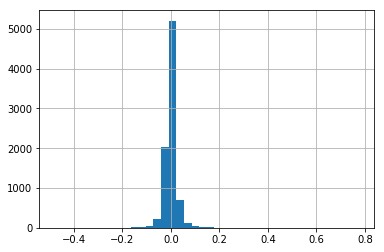

In [40]:
pred_compare = stack_predict.copy()
pred_compare['Stack'] = stack_test_preds
pred_compare['Stack_WYH'] = pred_compare['Stack'] - pred_compare['WYH']
pred_compare['Stack_WYH'].hist(bins=40)

In [57]:
test_X['y_pred']=pred_compare['Stack'].tolist()

In [60]:
test_X[test_X['I_A']==0.00][['I_A','y_pred']]

,I_A,y_pred
0,0.0,0.547199
855,0.0,0.324794
1543,0.0,0.346507
1714,0.0,0.347556
2583,0.0,0.335367
2930,0.0,0.337186
4123,0.0,0.344451
4300,0.0,0.346338
4462,0.0,0.342035
4632,0.0,0.417639


In [59]:
ans = test_X[['ID','y_pred']]
ans

,ID,y_pred
0,1,0.547199
1,9,1.304727
5,13,2.128413
9,17,3.415849
10,18,3.666793
13,21,4.217450
15,23,4.350903
17,25,4.787781
18,26,4.971161
20,28,5.287567


In [ ]:
index = ans[ans['ID'].isin(special_missing_ID)].index
ans.loc[index, 'y_pred'] = 0.379993053

count    8409.000000
mean        0.000324
std         0.032488
min        -0.479929
25%        -0.010521
50%        -0.000009
75%         0.010723
max         0.775440
Name: final_WYH, dtype: float64

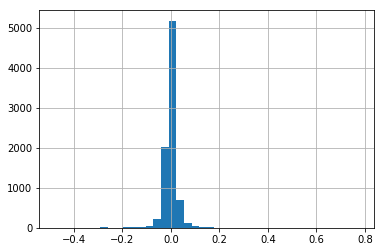

In [67]:
pred_compare['final'] = ans['y_pred'].tolist()
pred_compare['final_WYH'] = pred_compare['final']-pred_compare['WYH']
pred_compare['final_WYH'].hist(bins=40)
pred_compare['final_WYH'].describe()

In [68]:
ans[['ID','y_pred']].to_csv('../result/082001_08660.csv',header=False, index=False)